<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Load-the-loc_dict-(create-if-necessary)" data-toc-modified-id="Load-the-loc_dict-(create-if-necessary)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load the <code>loc_dict</code> (create if necessary)</a></span></li><li><span><a href="#Combine-to-pd.DataFrame" data-toc-modified-id="Combine-to-pd.DataFrame-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Combine to <code>pd.DataFrame</code></a></span></li></ul></li><li><span><a href="#Locations" data-toc-modified-id="Locations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Locations</a></span><ul class="toc-item"><li><span><a href="#Basic-Location-Stats" data-toc-modified-id="Basic-Location-Stats-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Basic Location Stats</a></span></li></ul></li><li><span><a href="#Create-Data-Splits" data-toc-modified-id="Create-Data-Splits-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create Data Splits</a></span><ul class="toc-item"><li><span><a href="#Create-country_indices-and-country_labels" data-toc-modified-id="Create-country_indices-and-country_labels-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Create <code>country_indices</code> and <code>country_labels</code></a></span></li><li><span><a href="#OOC-splits" data-toc-modified-id="OOC-splits-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>OOC splits</a></span></li><li><span><a href="#Incountry-splits" data-toc-modified-id="Incountry-splits-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Incountry splits</a></span></li><li><span><a href="#Urban-v.-Rural" data-toc-modified-id="Urban-v.-Rural-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Urban v. Rural</a></span></li></ul></li><li><span><a href="#Data-Analysis-by-Country" data-toc-modified-id="Data-Analysis-by-Country-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data Analysis by Country</a></span><ul class="toc-item"><li><span><a href="#Size" data-toc-modified-id="Size-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Size</a></span></li><li><span><a href="#Wealthpooled" data-toc-modified-id="Wealthpooled-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Wealthpooled</a></span></li><li><span><a href="#Urban-v.-Rural" data-toc-modified-id="Urban-v.-Rural-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Urban v. Rural</a></span></li><li><span><a href="#Nightlights" data-toc-modified-id="Nightlights-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Nightlights</a></span></li></ul></li><li><span><a href="#Data-Analysis-by-Split" data-toc-modified-id="Data-Analysis-by-Split-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data Analysis by Split</a></span><ul class="toc-item"><li><span><a href="#Wealthpooled" data-toc-modified-id="Wealthpooled-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Wealthpooled</a></span></li><li><span><a href="#Urban-v.-Rural" data-toc-modified-id="Urban-v.-Rural-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Urban v. Rural</a></span></li><li><span><a href="#Nightlights" data-toc-modified-id="Nightlights-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Nightlights</a></span></li></ul></li><li><span><a href="#Visualize-Images" data-toc-modified-id="Visualize-Images-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Visualize Images</a></span><ul class="toc-item"><li><span><a href="#Highest-wealth" data-toc-modified-id="Highest-wealth-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Highest wealth</a></span></li><li><span><a href="#Lowest-wealth" data-toc-modified-id="Lowest-wealth-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Lowest wealth</a></span></li></ul></li></ul></div>

Prerequisites:
1. Run the first couple of sections from `models/baselines_dhs.ipynb` to create `data/image_hists_dhs.npz`

# Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import defaultdict
import os
import pickle
from pprint import pprint
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

sys.path.append('/atlas/u/chrisyeh/africa_poverty/')
from batchers import batcher, dataset_constants
from data_analysis.create_folds import create_folds, verify_folds
from utils.geo_plot import setup_ax, plot_locs
from utils.general import colordisplay, load_npz
from utils.plot import boxplot_df, plot_image_by_band

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

FOLDS = ['A', 'B', 'C', 'D', 'E']
SPLITS = ['train', 'val', 'test']
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'TEMP1', 'SWIR2', 'NIR', 'NIGHTLIGHTS']
DATASET = '2009-17'

# Load data

In [4]:
file_path = '../data/image_hists_dhs.npz'
npz = load_npz(file_path)

labels = npz['labels']
locs = npz['locs']
years = npz['years']
nls_center = npz['nls_center']
nls_mean = npz['nls_mean']

num_examples = len(labels)
assert np.all(np.asarray([len(labels), len(locs), len(years)]) == num_examples)

image_hists: dtype=int64, shape=(19669, 8, 102)
labels: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
years: dtype=int32, shape=(19669,)
nls_center: dtype=float32, shape=(19669,)
nls_mean: dtype=float32, shape=(19669,)


## Load the `loc_dict` (create if necessary)

`loc_dict` has the format:
```python
{
    (lat, lon): {
        'cluster': 1,
        'country': 'malawi',
        'country_year': 'malawi_2012',  # surveyID
        'households': 25,
        'urban': False,
        'wealth': -0.513607621192932,
        'wealthpooled': -0.732255101203918,
        'year': 2012
    }, ...
}
```

NOTE: `year` and `country_year` might differ in the year. `country_year` is the survey ID, which says which year the survey started. However, sometimes the DHS surveys cross the year-boundary, in which case `country_year` will remain the same but `year` will be the next year.

In [5]:
def create_loc_dict(loc_dict_path):
    '''
    Args
    - loc_dict_path: str, path to save the loc_dict
    '''
    surveys_df = pd.read_csv('../data/dhs_wealth_index.csv', float_precision='high')
    surveys_df.rename({'LATNUM': 'lat', 'LONGNUM': 'lon', 'URBAN_RURA': 'urban'},
                      axis='columns', inplace=True)
    for col in ['lat', 'lon', 'wealthpooled', 'wealth', 'wealthpooled5country']:
        surveys_df[col] = surveys_df[col].astype(np.float32)
    surveys_df['country'] = (surveys_df['country']
                             .str.lower()
                             .str.replace(' ', '_')
                             .str.replace("'", '_'))

    loc_dict = {}
    for (lat, lon) in locs:
        loc = (lat, lon)
        row = surveys_df.loc[(surveys_df['lat'] == lat) & (surveys_df['lon'] == lon), :]
        assert len(row) == 1
        row = row.iloc[0]

        cy = '{c}_{y}'.format(c=row['country'], y=row['svyid'][-4:])

        assert loc not in loc_dict
        loc_dict[loc] = {
            'cluster': row['cluster'],
            'country': row['country'],
            'country_year': cy,  # surveyID
            'households': row['households'],
            'urban': row['urban'] == 'U',
            'wealth': row['wealth'],
            'wealthpooled': row['wealthpooled'],
            'year': row['year']
        }

    with open(loc_dict_path, 'wb') as f:
        pickle.dump(loc_dict, f)

In [6]:
loc_dict_path = '../data/dhs_loc_dict.pkl'

if not os.path.exists(loc_dict_path):
    create_loc_dict(loc_dict_path)

with open(loc_dict_path, 'rb') as f:
    loc_dict = pickle.load(f)

## Combine to `pd.DataFrame`

In [7]:
df_data = []
for label, loc, nl_mean, nl_center in zip(labels, locs, nls_mean, nls_center):
    lat, lon = loc
    loc_info = loc_dict[(lat, lon)]
    year = int(loc_info['country_year'][-4:])  # use the year matching the surveyID
    row = [lat, lon, label, loc_info['country'], year, loc_info['urban'], nl_mean, nl_center]
    df_data.append(row)
df = pd.DataFrame.from_records(
    df_data,
    columns=['lat', 'lon', 'wealthpooled', 'country', 'year', 'urban', 'nl_mean', 'nl_center'])

In [8]:
with pd.option_context('display.max_rows', 4):
    display(df)

lat        lon  wealthpooled   country  year  urban   nl_mean  \
0     -11.915085  22.876839     -1.019361    angola  2011  False -0.086633   
1     -11.886975  22.924997     -1.090052    angola  2011  False -0.097684   
...          ...        ...           ...       ...   ...    ...       ...   
19667 -17.989489  31.033354      1.882921  zimbabwe  2015   True  0.515834   
19668 -17.998350  31.042618      1.880099  zimbabwe  2015   True  0.844067   

       nl_center  
0       0.016189  
1      -0.173862  
...          ...  
19667   1.890566  
19668   1.456959  

[19669 rows x 8 columns]

# Locations

## Basic Location Stats

Lat. min: -30.588812, max: 16.580605
Lon. min: -17.478474, max: 47.007919

maximum side_lat: 0.060570
maximum side_lon: 0.070361


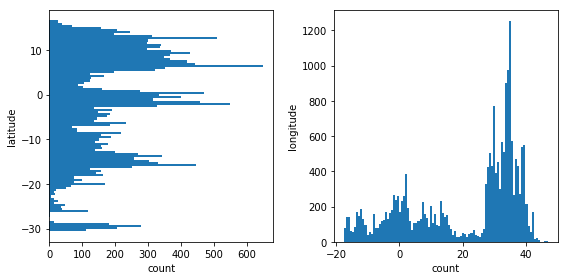

In [9]:
RADIUS_EARTH = 6356.7523  # in km, polar radius of Earth

def get_lon_for_distance(lat, d):
    '''Calculates the degrees longitude for some East-West distance at a given latitude.

    Makes (incorrect) assumption that Earth is a perfect sphere.
    Uses the smaller polar radius (instead of equatorial radius), so
        actual degrees longitude <= returned value

    Args
    - lat: numeric, latitude in degrees
    - d: numeric, distance in km

    Returns
    - lon: float, approximate degrees longitude
    '''
    lat = np.abs(lat) * np.pi / 180.0  # convert to radians
    r = RADIUS_EARTH * np.cos(lat)  # radius at the given lat
    lon = d / r
    lon = lon * 180.0 / np.pi  # convert to degrees
    return lon

def get_lat_for_distance(d):
    '''Calculates the degrees latitude for some North-South distance.

    Makes (incorrect) assumption that Earth is a perfect sphere.
    Uses the smaller polar radius (instead of equatorial radius), so
        actual degrees latitude <= returned value

    Args
    - d: numeric, distance in km

    Returns
    - lat: float, approximate degrees latitude
    '''
    lat = d / RADIUS_EARTH  # in radians
    lat = lat * 180.0 / np.pi  # convert to degrees
    return lat

def print_loc_stats(locs):
    '''
    Args
    - locs: np.array, shape [N, 2], each row is [lat, lon] in degrees
        assumes lat values are + for N, - for S
        assumes lon values are + for E, - for W
    '''
    min_lat, min_lon = np.min(locs, axis=0)
    max_lat, max_lon = np.max(locs, axis=0)
    print(f'Lat. min: {min_lat:.6f}, max: {max_lat:.6f}')
    print(f'Lon. min: {min_lon:.6f}, max: {max_lon:.6f}')
    print()

    # get maximum lat/lon side-lengths for a 224x224 pixel image at 30m / px
    side_distance = 224 * 30 / 1000
    farthest_lat = max(abs(min_lat), abs(max_lat))
    side_lat = get_lat_for_distance(d=side_distance)
    side_lon = get_lon_for_distance(lat=farthest_lat, d=side_distance)
    print(f'maximum side_lat: {side_lat:.6f}')
    print(f'maximum side_lon: {side_lon:.6f}')

def plot_locs_histogram(locs):
    # plot histogram of locations
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[8, 4])

    # latitudes
    axs[0].hist(locs[:, 0], bins=100, orientation='horizontal')
    axs[0].set(xlabel='count', ylabel='latitude')

    # longitudes
    axs[1].hist(locs[:, 1], bins=100, orientation='vertical')
    axs[1].set(xlabel='count', ylabel='longitude')

    fig.tight_layout()
    plt.show()

print_loc_stats(locs)
plot_locs_histogram(locs)

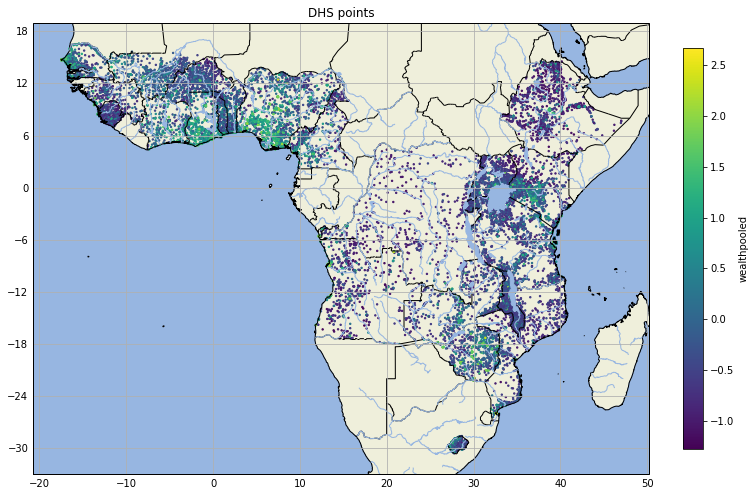

In [10]:
_ = plot_locs(locs=locs, colors=labels, figsize=[12, 13],
              title='DHS points', cbar_label='wealthpooled')

# Create Data Splits

In [11]:
def plot_splits(locs_dict, title=None):
    '''
    Args
    - locs_dict: dict, label (str) => np.array of lat, lon
    '''
    fig = plt.figure(figsize=[15, 15])
    ax = setup_ax(fig)

    for label, locs_array in locs_dict.items():
        ax.scatter(locs_array[:, 1], locs_array[:, 0], label=label, s=2)

    lgd = ax.legend()
    for handle in lgd.legendHandles:
        handle.set_sizes([50.0])

    if title is not None:
        ax.set_title(title)
    plt.show()

## Create `country_indices` and `country_labels`

`country_indices` is a dictionary that maps a country name to a sorted `np.array` of its indices
```python
{ 'malawi': np.array([ 8530,  8531,  8532, ..., 10484, 10485, 10486]), ... }
```

`country_labels` is a `np.array` that shows which country each example belongs to
```python
np.array([0, 0, 0, 0, ..., 22, 22, 22])
```
where countries are indexed by their position in `dataset_constants.DHS_COUNTRIES`

In [12]:
country_indices = defaultdict(list)  # country => np.array of indices
country_labels = np.zeros(len(locs), dtype=np.int32)  # np.array of country labels

for i, loc in enumerate(locs):
    country = loc_dict[tuple(loc)]['country']
    country_indices[country].append(i)

for i, country in enumerate(dataset_constants.DHS_COUNTRIES):
    country_indices[country] = np.asarray(country_indices[country])
    indices = country_indices[country]
    country_labels[indices] = i

## OOC splits

In [13]:
# 'A': {
#     'train': np.array([1, 10, 13, ...]),
#     ...
# }
ooc_folds = {
    f: {split: [] for split in SPLITS}
    for f in FOLDS
}

for f in FOLDS:
    surveys_dict = dataset_constants.SURVEY_NAMES[f'2009-17{f}']
    for split, countries in surveys_dict.items():
        split_indices = np.sort(np.concatenate([
            country_indices[country] for country in countries
        ]))
        ooc_folds[f][split] = split_indices

pprint({
    f: {split: len(ooc_folds[f][split])
        for split in SPLITS}
    for f in ooc_folds
})

{'A': {'test': 3963, 'train': 11797, 'val': 3909},
 'B': {'test': 3909, 'train': 11820, 'val': 3940},
 'C': {'test': 3940, 'train': 11800, 'val': 3929},
 'D': {'test': 3929, 'train': 11812, 'val': 3928},
 'E': {'test': 3928, 'train': 11778, 'val': 3963}}


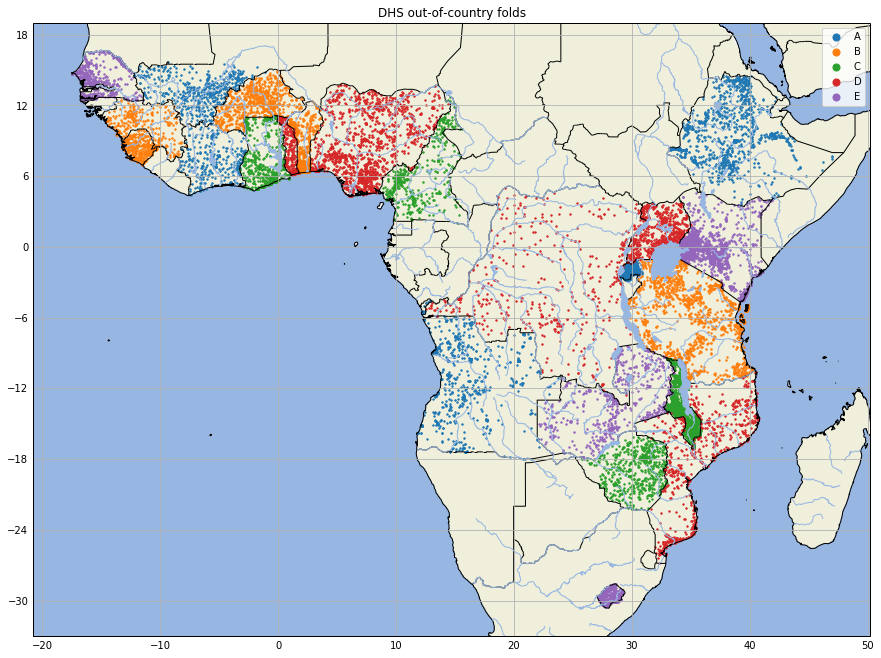

In [14]:
plot_splits({f: locs[ooc_folds[f]['test']] for f in FOLDS},
            title='DHS out-of-country folds')

## Incountry splits

Maximum side lengths in degrees lat/lon of a 224x224 px image at 30m/px

```
maximum side_lat: 0.060570
maximum side_lon: 0.070361
```

In [15]:
def create_incountry_folds(locs, folds_path):
    '''
    Args
    - locs: np.array, shape [N, 2], each row is [lat, lon]
    - folds_path: str, path to save incountry folds dict
    '''
    MIN_DIST = 0.092841  # sqrt(0.060570**2 + 0.070361**2)
    DIST_METRIC = 'euclidean'
    MAX_INDEX = 19669

    locs_to_indices, test_folds = create_folds(
        locs, min_dist=MIN_DIST, dist_metric=DIST_METRIC, fold_names=FOLDS,
        plot_largest_clusters=5)
    verify_folds(test_folds, locs=locs, min_dist=MIN_DIST,
                 dist_metric=DIST_METRIC, max_index=MAX_INDEX)

    print('Size of each fold')
    pprint({f: len(indices) for f, indices in test_folds.items()})

    # create train/val/test splits
    folds = {}
    for i, f in enumerate(FOLDS):
        folds[f] = {}
        folds[f]['test'] = test_folds[f]

        val_f = FOLDS[(i+1) % 5]
        folds[f]['val'] = test_folds[val_f]

        train_fs = [FOLDS[(i+2) % 5], FOLDS[(i+3) % 5], FOLDS[(i+4) % 5]]
        folds[f]['train'] = np.sort(np.concatenate([test_folds[f] for f in train_fs]))

    if os.path.exists(folds_path):
        with open(folds_path, 'rb') as f:
            existing_folds = pickle.load(f)
        for f in FOLDS:
            for s in SPLITS:
                assert np.array_equal(folds[f][s], existing_folds[f][s])
    else:
        with open(folds_path, 'wb') as f:
            pickle.dump(folds, f)

num clusters: 1988
max cluster size: 983
num outliers: 4939


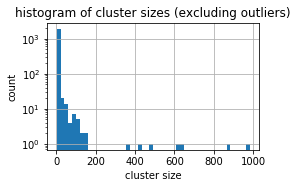

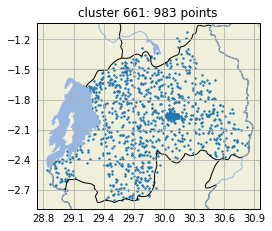

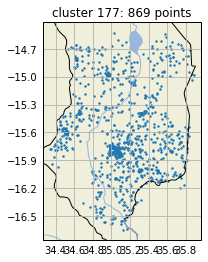

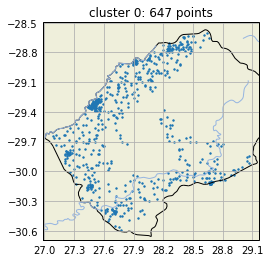

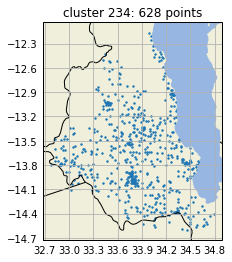

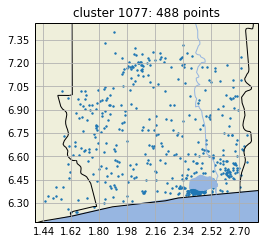

A B 0.09310241420442118
A C 0.09317625582917934
A D 0.09300533487256789
A E 0.09297408904936012
B C 0.09297475148184128
B D 0.09294837138834745
B E 0.09286229441878976
C D 0.09305275418115545
C E 0.09288848701489168
D E 0.09297549525505677
Size of each fold
{'A': 3934, 'B': 3934, 'C': 3934, 'D': 3934, 'E': 3933}
{'A': {'test': 3934, 'train': 11801, 'val': 3934},
 'B': {'test': 3934, 'train': 11801, 'val': 3934},
 'C': {'test': 3934, 'train': 11801, 'val': 3934},
 'D': {'test': 3934, 'train': 11802, 'val': 3933},
 'E': {'test': 3933, 'train': 11802, 'val': 3934}}


In [16]:
incountry_folds_path = '../data/dhs_incountry_folds.pkl'

create_incountry_folds(locs, incountry_folds_path)
with open(incountry_folds_path, 'rb') as f:
    incountry_folds = pickle.load(f)

pprint({
    f: {split: len(incountry_folds[f][split])
        for split in SPLITS}
    for f in ooc_folds
})

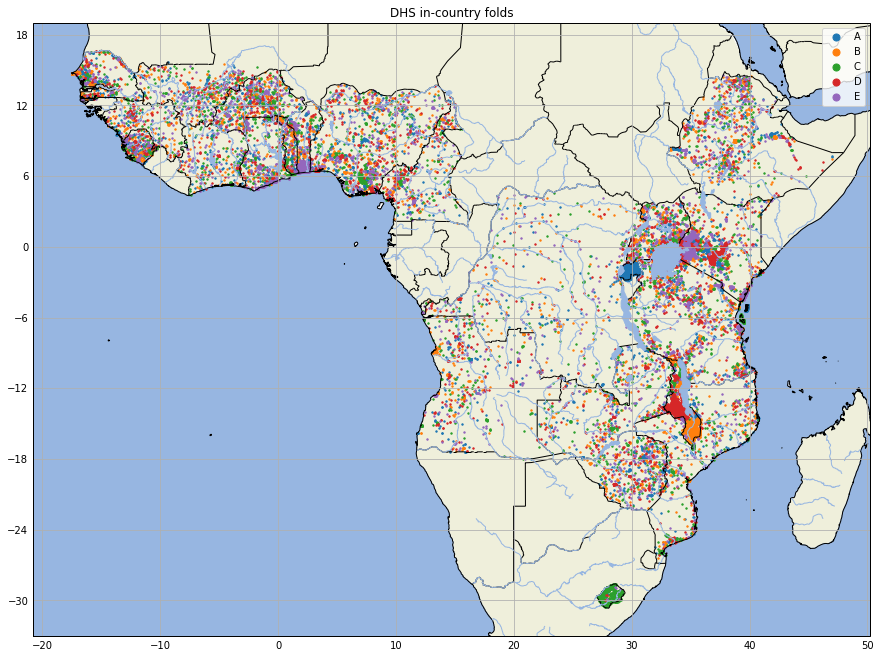

In [17]:
plot_splits({f: locs[incountry_folds[f]['test']] for f in FOLDS},
            title='DHS in-country folds')

In [18]:
def plot_counts(folds, countries, country_indices):
    '''
    Args
    - folds: dict, folds[f][split] is a np.array of indices
    - countries: list of str, names of countries
    - country_indices: dict, country (str) => np.array of indices
    '''
    counts = np.zeros([len(countries), len(FOLDS)], dtype=np.float32)
    for i, country in enumerate(countries):
        idxs = country_indices[country]
        for j, f in enumerate(FOLDS):
            counts[i, j] = len(np.intersect1d(folds[f]['test'], idxs))
    counts /= np.sum(counts, axis=1, keepdims=True)
    folds_df = pd.DataFrame(data=counts, columns=FOLDS, index=countries)

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    folds_df.plot.barh(ax=ax, stacked=True, width=0.8)
    ax.set_xlabel('fraction')
    fig.tight_layout()

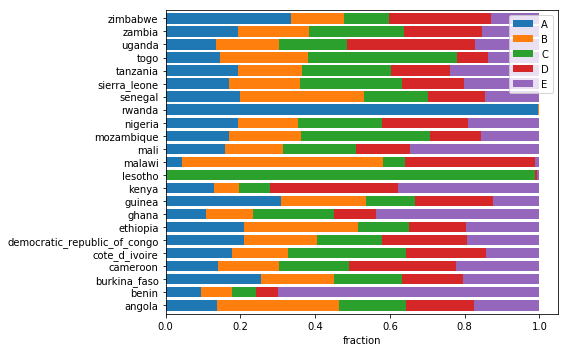

In [19]:
plot_counts(folds=incountry_folds,
            countries=dataset_constants.DHS_COUNTRIES,
            country_indices=country_indices)

# as a sanity check, each country in `ooc_folds` should have a single solid color
# plot_counts(folds=ooc_folds,
#             countries=dataset_constants.DHS_COUNTRIES,
#             country_indices=country_indices)

## Urban v. Rural

In [20]:
def get_urban_rural_indices(locs, loc_dict):
    '''
    Args
    - locs: np.array, shape [N, 2]
    - loc_dict: dict, maps (lat, lon) => dict of info

    Returns
    - urban_indices: np.array, shape [num_urban]
    - rural_indices: np.array, shape [num_rural]
    '''
    urban_indices = []
    rural_indices = []

    for i, loc in enumerate(locs):
        loc = tuple(loc)
        if loc_dict[loc]['urban'] == 0:
            rural_indices.append(i)
        else:
            urban_indices.append(i)
    urban_indices = np.asarray(urban_indices)
    rural_indices = np.asarray(rural_indices)
    print('num urban: {}\t num rural: {}'.format(len(urban_indices), len(rural_indices)))
    return urban_indices, rural_indices

urban_indices, rural_indices = get_urban_rural_indices(locs, loc_dict)

num urban: 6801	 num rural: 12868


In [21]:
urban_counts = {}
rural_counts = {}

for f, splits in ooc_folds.items():
    urban_counts[f] = {}
    rural_counts[f] = {}
    for s, indices in splits.items():
        urban_counts[f][s] = len(np.intersect1d(urban_indices, indices))
        rural_counts[f][s] = len(np.intersect1d(rural_indices, indices))

for f in ooc_folds:
    urban_counts[f]['all'] = sum(urban_counts[f].values())
    rural_counts[f]['all'] = sum(rural_counts[f].values())

print('urban counts')
pprint(urban_counts)
print('rural counts')
pprint(rural_counts)

urban counts
{'A': {'all': 6801, 'test': 1316, 'train': 4264, 'val': 1221},
 'B': {'all': 6801, 'test': 1221, 'train': 4225, 'val': 1355},
 'C': {'all': 6801, 'test': 1355, 'train': 4010, 'val': 1436},
 'D': {'all': 6801, 'test': 1436, 'train': 3892, 'val': 1473},
 'E': {'all': 6801, 'test': 1473, 'train': 4012, 'val': 1316}}
rural counts
{'A': {'all': 12868, 'test': 2647, 'train': 7533, 'val': 2688},
 'B': {'all': 12868, 'test': 2688, 'train': 7595, 'val': 2585},
 'C': {'all': 12868, 'test': 2585, 'train': 7790, 'val': 2493},
 'D': {'all': 12868, 'test': 2493, 'train': 7920, 'val': 2455},
 'E': {'all': 12868, 'test': 2455, 'train': 7766, 'val': 2647}}


# Data Analysis by Country

In [22]:
COUNTRIES = sorted(df['country'].unique())
pprint(COUNTRIES, compact=True)

YEARS = sorted(df['year'].unique())
pprint(YEARS, compact=True)

['angola', 'benin', 'burkina_faso', 'cameroon', 'cote_d_ivoire',
 'democratic_republic_of_congo', 'ethiopia', 'ghana', 'guinea', 'kenya',
 'lesotho', 'malawi', 'mali', 'mozambique', 'nigeria', 'rwanda', 'senegal',
 'sierra_leone', 'tanzania', 'togo', 'uganda', 'zambia', 'zimbabwe']
[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


## Size

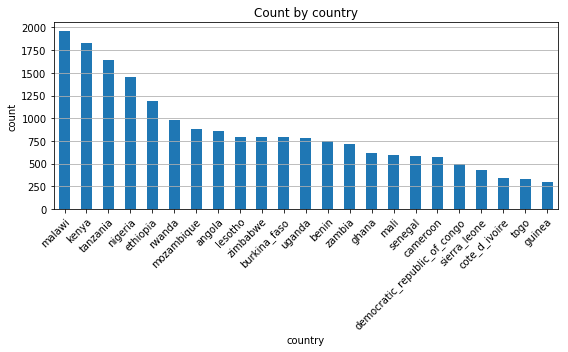

In [23]:
def plot_countries_by_size(df):
    counts = df.groupby('country').size()
    counts.sort_values(inplace=True, ascending=False)

    fig, ax = plt.subplots(1, 1, figsize=[8, 5])
    counts.to_frame().plot(kind='bar', ax=ax, legend=None)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')
    ax.set_ylabel('count')
    ax.set_title('Count by country')
    ax.grid(True, axis='y')
    fig.tight_layout()
    plt.show()

plot_countries_by_size(df)

In [24]:
with pd.option_context('display.max_rows', 100):
    counts_series = df.groupby(['country', 'year']).size().rename('count')
    display(counts_series.to_frame())

count
country                      year       
angola                       2011    230
                             2015    625
benin                        2012    746
burkina_faso                 2010    541
                             2014    248
cameroon                     2011    576
cote_d_ivoire                2012    341
democratic_republic_of_congo 2013    492
ethiopia                     2010    571
                             2016    622
ghana                        2014    422
                             2016    192
guinea                       2012    300
kenya                        2014   1585
                             2015    245
lesotho                      2009    395
                             2014    399
malawi                       2010    827
                             2012    140
                             2014    140
                             2015    850
mali                         2012    413
                             2015    177
mozambique                   2009    270
                             2011    609
nigeria                      2010    239
                             2013    889
                             2015    322
rwanda                       2010    492
                             2014    492
senegal                      2010    385
                             2012    200
sierra_leone                 2013    435
tanzania                     2010    458
                             2011    573
                             2015    608
togo                         2013    330
uganda                       2009    170
                             2011    400
                             2014    208
zambia                       2013    719
zimbabwe                     2010    393
                             2015    400

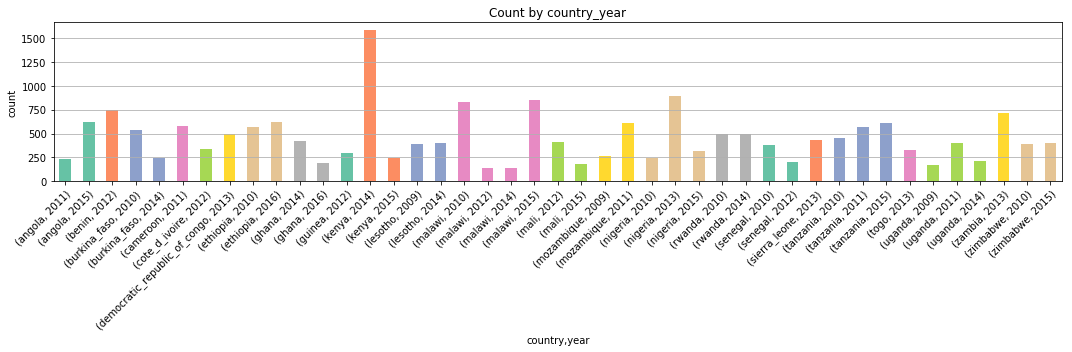

In [25]:
def plot_cy_by_size(df, country_year_colors):
    fig, ax = plt.subplots(1, 1, figsize=[15, 5])
    df.groupby(['country', 'year']).size().plot(
        kind='bar', ax=ax, color=country_year_colors)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    ax.set_ylabel('count')
    ax.set_title('Count by country_year')
    ax.grid(True, axis='y')
    fig.tight_layout()
    plt.show()

country_year_index = df.groupby(['country', 'year']).size().index
CMAP_FN = plt.cm.get_cmap('Set2')
COUNTRY_YEAR_COLORS = [CMAP_FN.colors[i % 8] for i in country_year_index.codes[0]]
plot_cy_by_size(df, COUNTRY_YEAR_COLORS)

## Wealthpooled

In [26]:
df_country = df.groupby('country')['wealthpooled'].describe()
colordisplay(df_country)

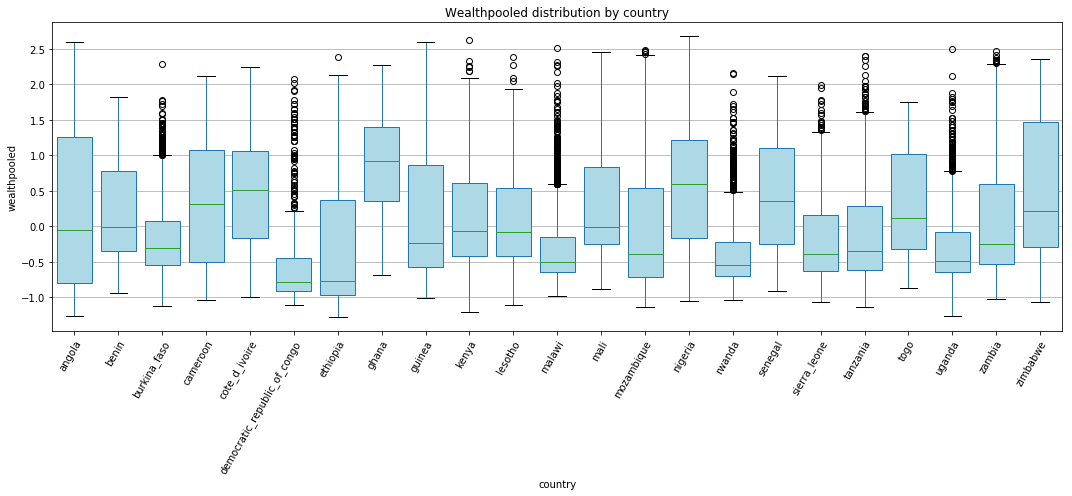

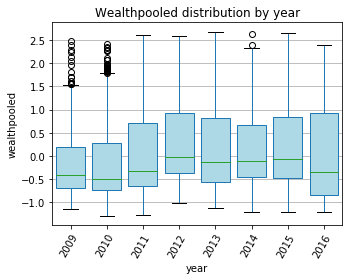

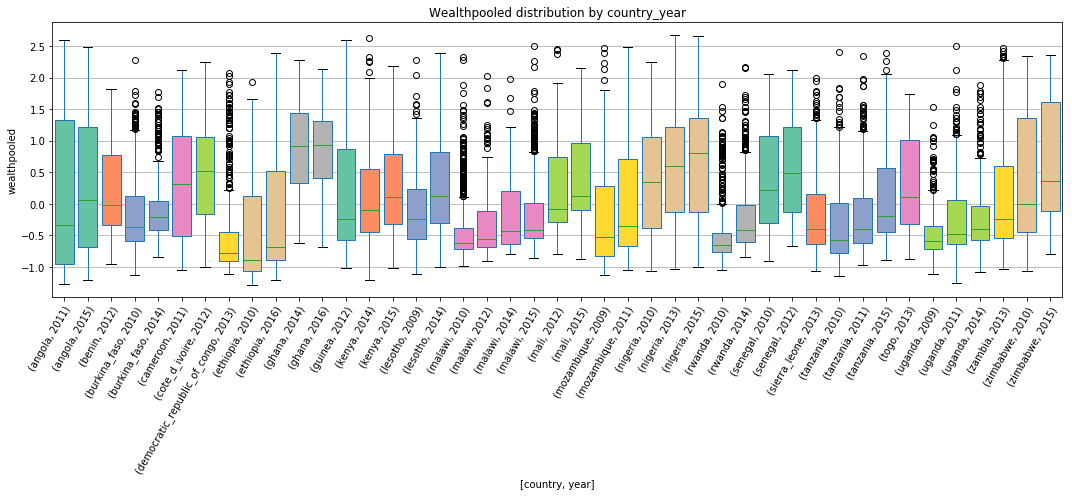

In [27]:
boxplot_df(df, y='wealthpooled', by='country',
           figsize=(15, 7), ylabel='wealthpooled',
           title='Wealthpooled distribution by country',
           colors=['lightblue' for _ in COUNTRIES])

boxplot_df(df, y='wealthpooled', by='year',
           figsize=(5, 4), ylabel='wealthpooled',
           title='Wealthpooled distribution by year',
           colors=['lightblue' for _ in YEARS])

boxplot_df(df, y='wealthpooled', by=['country', 'year'],
           figsize=(15, 7), ylabel='wealthpooled',
           title='Wealthpooled distribution by country_year',
           colors=COUNTRY_YEAR_COLORS)

## Urban v. Rural

In [28]:
def plot_urban_rural(df, by, color=None, title=None):
    '''
    Args
    - df: pd.DataFrame
    - by: str or list of str, column(s) to group by
    - color: list of colors
    - title: str
    '''
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), constrained_layout=True)
    urban_series = df.groupby(by)['urban'].mean()
    if color is None:
        urban_series.plot(kind='bar', ax=ax, width=0.8)
    else:
        urban_series.plot(kind='bar', ax=ax, color=color, width=0.8)
    plt.setp(ax.get_xticklabels(), rotation=60, ha='right',
             rotation_mode='anchor')
    if title is not None:
        ax.set_title(title)
    ax.grid(True, axis='y')
    ax.set_ylabel('fraction urban')

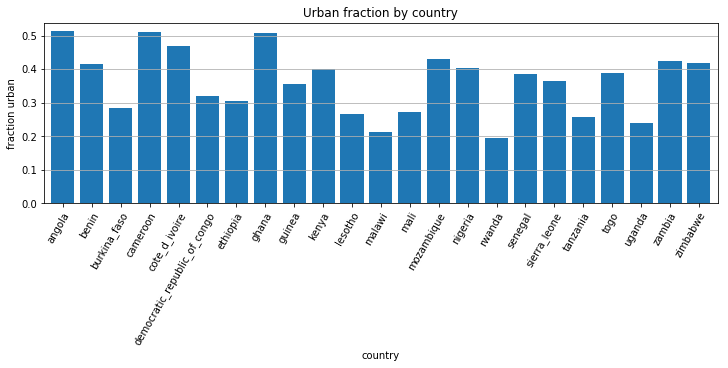

In [29]:
plot_urban_rural(df, by='country', title='Urban fraction by country')

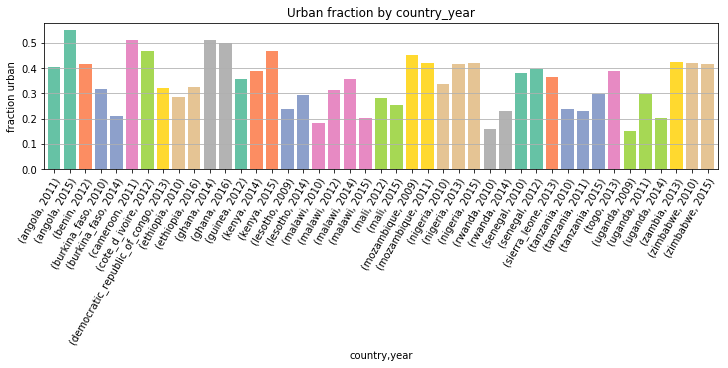

In [30]:
plot_urban_rural(df, by=['country', 'year'],
                 color=COUNTRY_YEAR_COLORS,
                 title='Urban fraction by country_year')

## Nightlights

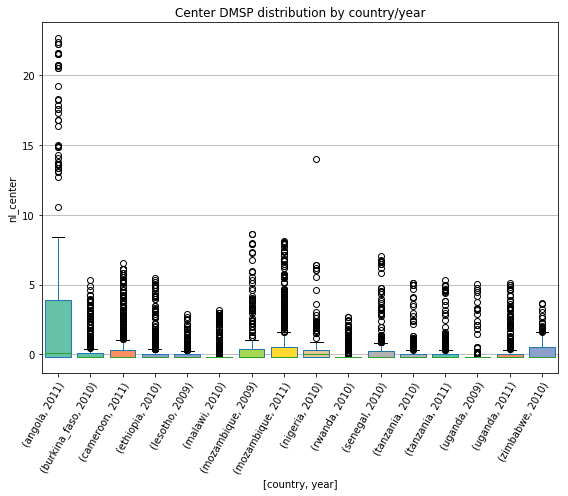

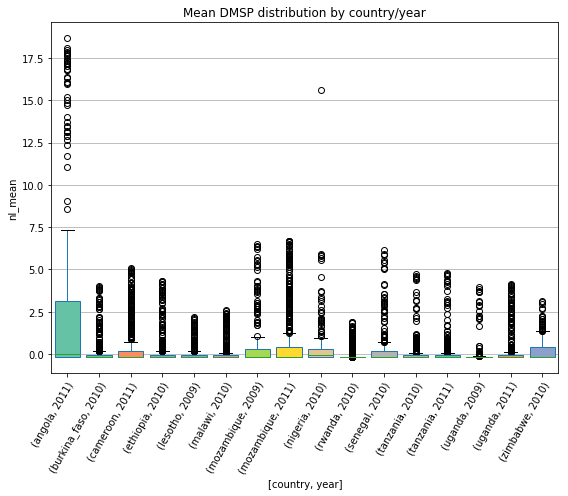

In [31]:
boxplot_df(df[df['year'] < 2012], y='nl_center', by=['country', 'year'],
           figsize=(8, 7), ylabel='nl_center',
           title='Center DMSP distribution by country/year',
           colors=COUNTRY_YEAR_COLORS)

boxplot_df(df[df['year'] < 2012], y='nl_mean', by=['country', 'year'],
           figsize=(8, 7), ylabel='nl_mean',
           title='Mean DMSP distribution by country/year',
           colors=COUNTRY_YEAR_COLORS)

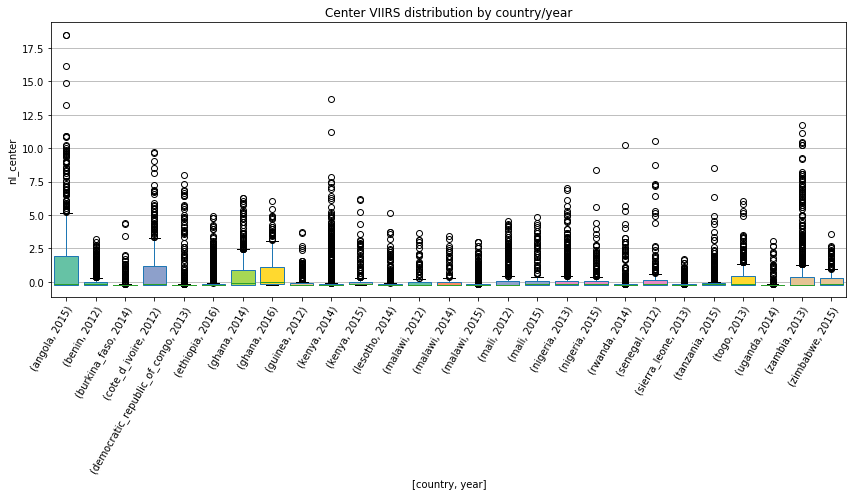

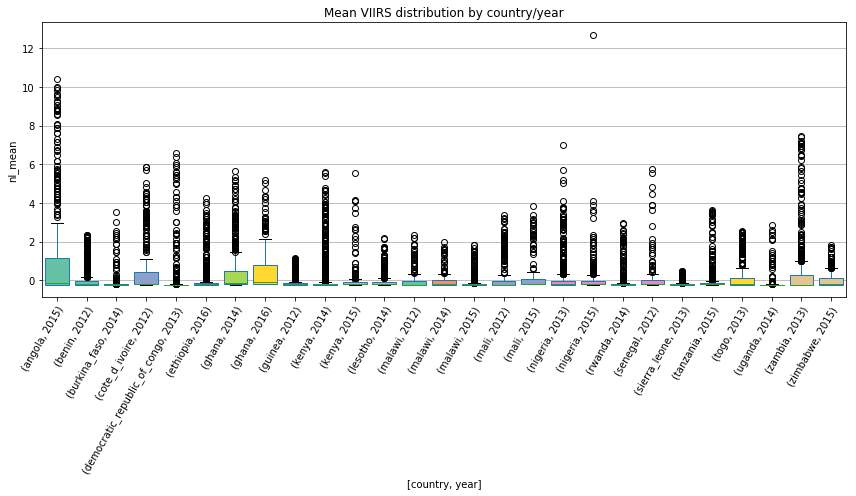

In [32]:
boxplot_df(df[df['year'] >= 2012], y='nl_center', by=['country', 'year'],
           figsize=(12, 7), ylabel='nl_center',
           title='Center VIIRS distribution by country/year',
           colors=COUNTRY_YEAR_COLORS)

boxplot_df(df[df['year'] >= 2012], y='nl_mean', by=['country', 'year'],
           figsize=(12, 7), ylabel='nl_mean',
           title='Mean VIIRS distribution by country/year',
           colors=COUNTRY_YEAR_COLORS)

# Data Analysis by Split

## Wealthpooled

In [33]:
def plot_labels_by_fold(labels, folds, title=None):
    '''
    Args
    - labels: np.array, shape [N], type float32
    - folds: dict, folds[f][split] is a np.array of indices
    - title: str, figure title
    '''
    fig, axs = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(8, 3.5))
    for f, ax in zip(FOLDS, axs.flat):
        data = [labels[folds[f][split]] for split in SPLITS]
        ax.boxplot(data, patch_artist=True, widths=0.8)

        # add x-tick labels
        plt.setp(ax, xticks=[1, 2, 3], xticklabels=SPLITS)

        ax.grid(True, axis='y')
        ax.set_title(f'Fold: {f}')

    axs[0].set_ylabel('wealthpooled')
    if title is not None:
        fig.suptitle(title, y=1.03)
    fig.tight_layout()

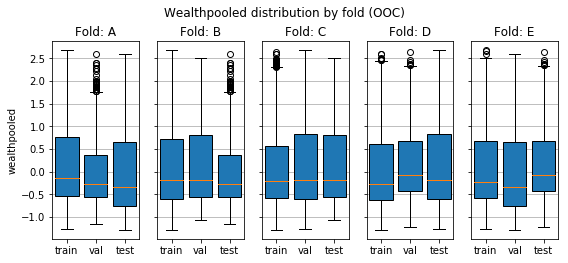

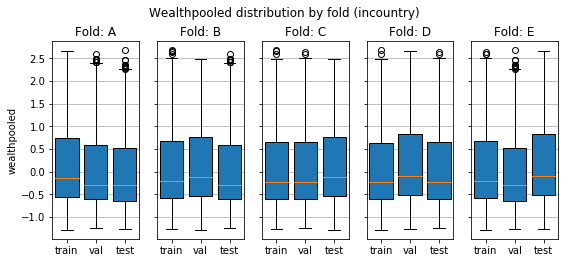

In [34]:
plot_labels_by_fold(labels, ooc_folds, title='Wealthpooled distribution by fold (OOC)')
plot_labels_by_fold(labels, incountry_folds, title='Wealthpooled distribution by fold (incountry)')

In [35]:
def plot_label_hists(labels, folds, title=None):
    '''
    Args
    - labels: np.array, shape [N], type float32
    - folds: dict, folds[f][split] is a np.array of indices
    - title: str, figure title
    '''
    fig, axs = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(15, 3))
    LABEL_BIN_EDGES = np.arange(-1.5, 3.0, 0.1)
    bin_centers = np.convolve(LABEL_BIN_EDGES, [.5, .5], mode='valid')

    for f, ax in zip(FOLDS, axs.flat):
        for split in SPLITS:
            label_hist, _ = np.histogram(a=labels[folds[f][split]], bins=LABEL_BIN_EDGES)
            ax.plot(bin_centers, label_hist / np.sum(label_hist), label=split)
        ax.set_xlabel('wealthpooled')
        ax.set_title(f'Fold {f}')
        ax.grid(True)

    axs[0].legend()
    axs[0].set_ylabel('fraction')
    if title is not None:
        fig.suptitle(title, y=1.03)
    fig.tight_layout()

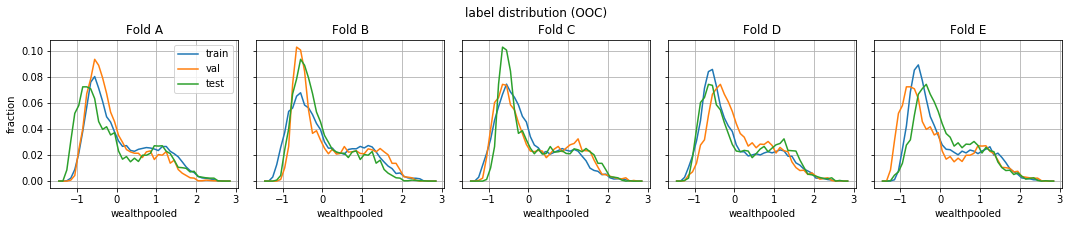

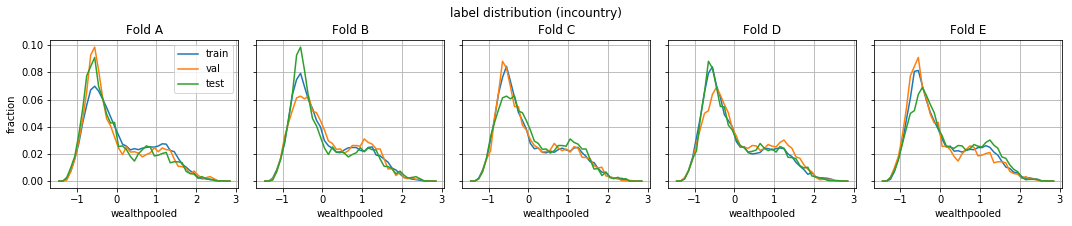

In [36]:
plot_label_hists(labels, ooc_folds, title='label distribution (OOC)')
plot_label_hists(labels, incountry_folds, title='label distribution (incountry)')

## Urban v. Rural

In [37]:
def plot_urban_by_fold(urban, folds, title=None):
    '''
    Args
    - urban: np.array, shape [N], type bool
    - folds: dict, folds[f][split] is a np.array of indices
    - title: str, figure title
    '''
    fig, axs = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(8, 3.5))
    for f, ax in zip(FOLDS, axs.flat):
        data = [urban[folds[f][split]].mean() for split in SPLITS]
        ax.bar([0, 1, 2], data, width=0.8)

        # add x-tick labels
        plt.setp(ax, xticks=[0, 1, 2], xticklabels=SPLITS)

        ax.grid(True, axis='y')
        ax.set_title(f'Fold: {f}')

    axs[0].set_ylabel('urban fraction')
    if title is not None:
        fig.suptitle(title, y=1.03)
    fig.tight_layout()

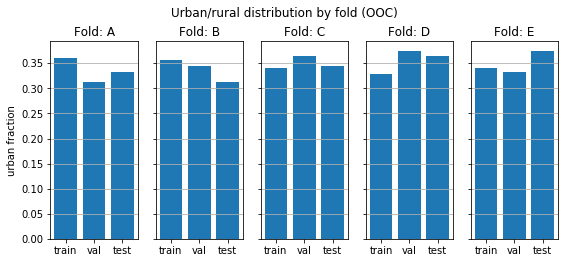

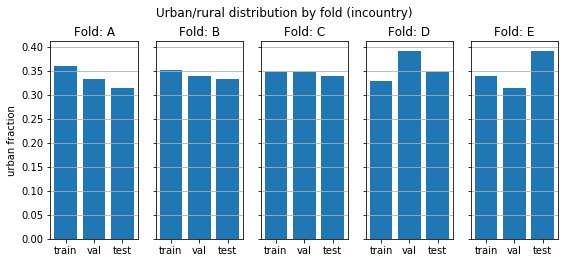

In [38]:
plot_urban_by_fold(df['urban'].values, ooc_folds, title='Urban/rural distribution by fold (OOC)')
plot_urban_by_fold(df['urban'].values, incountry_folds, title='Urban/rural distribution by fold (incountry)')

## Nightlights

In [39]:
def plot_nl_by_fold(df, folds, col, dmsp, title=None):
    '''
    Args
    - df: pd.DataFrame
    - folds: dict, folds[f][split] is a np.array of indices
    - col: str, one of ['nl_mean', 'nl_center']
    - dmsp: bool
    - title: str, figure title
    '''
    fig, axs = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(15, 3))
    bin_edges = np.linspace(start=df[col].min()-0.1, stop=df[col].max()+0.1, num=100)
    bin_centers = np.convolve(bin_edges, [.5, .5], mode='valid')

    for f, ax in zip(FOLDS, axs.flat):
        for split in SPLITS:
            nls_df = df.loc[folds[f][split], [col, 'year']]
            if dmsp:
                nl_hist, _ = np.histogram(
                    nls_df.loc[nls_df['year'] < 2012, col],
                    bins=bin_edges)
            else:
                nl_hist, _ = np.histogram(
                    nls_df.loc[nls_df['year'] >= 2012, col],
                    bins=bin_edges)
            ax.plot(bin_centers, nl_hist / np.sum(nl_hist), label=split)
        ax.set_xlabel(col)
        ax.set_yscale('log')
        ax.set_title(f'Fold {f}')
        ax.grid(True)

    axs[0].legend()
    axs[0].set_ylabel('fraction')
    if title is not None:
        fig.suptitle(title, y=1.03)
    fig.tight_layout()

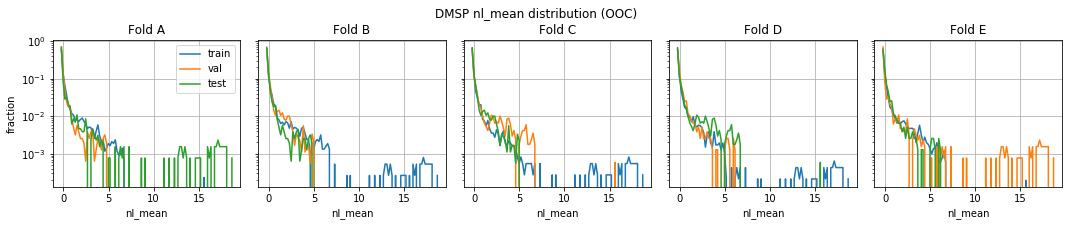

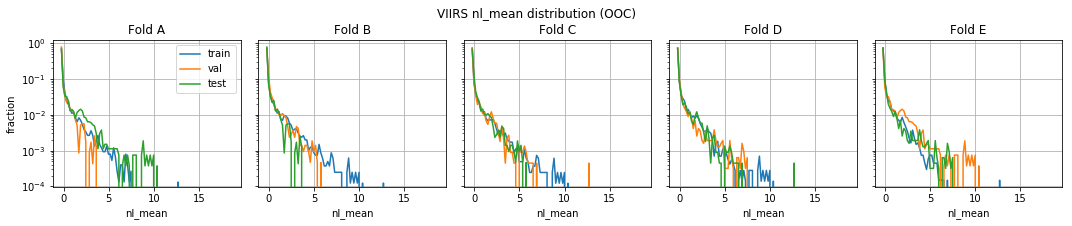

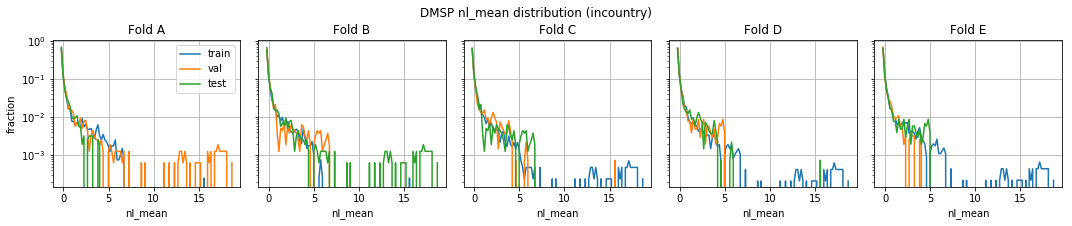

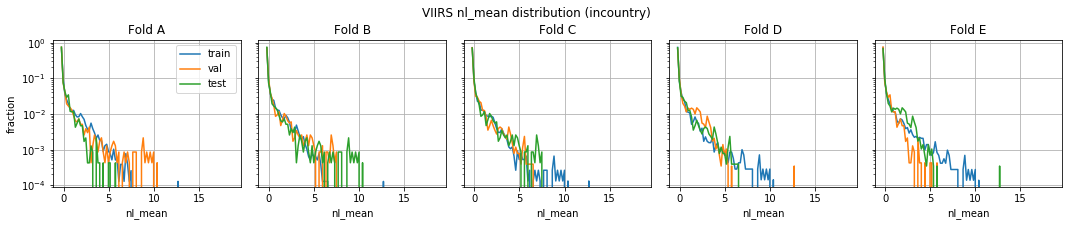

In [40]:
plot_nl_by_fold(df, ooc_folds, col='nl_mean', dmsp=True, title='DMSP nl_mean distribution (OOC)')
plot_nl_by_fold(df, ooc_folds, col='nl_mean', dmsp=False, title='VIIRS nl_mean distribution (OOC)')
plot_nl_by_fold(df, incountry_folds, col='nl_mean', dmsp=True, title='DMSP nl_mean distribution (incountry)')
plot_nl_by_fold(df, incountry_folds, col='nl_mean', dmsp=False, title='VIIRS nl_mean distribution (incountry)')

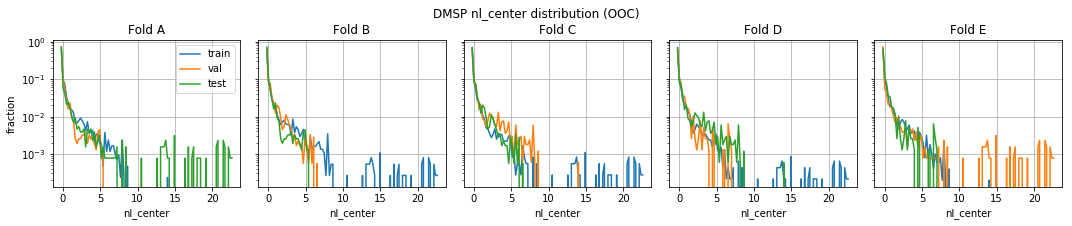

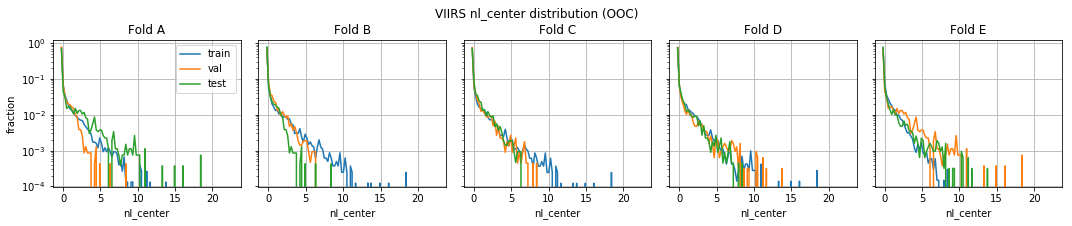

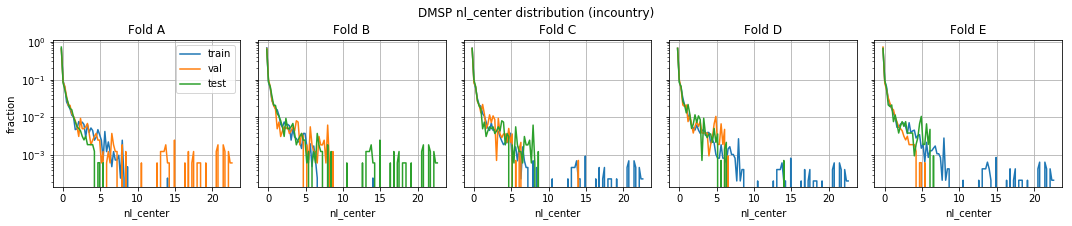

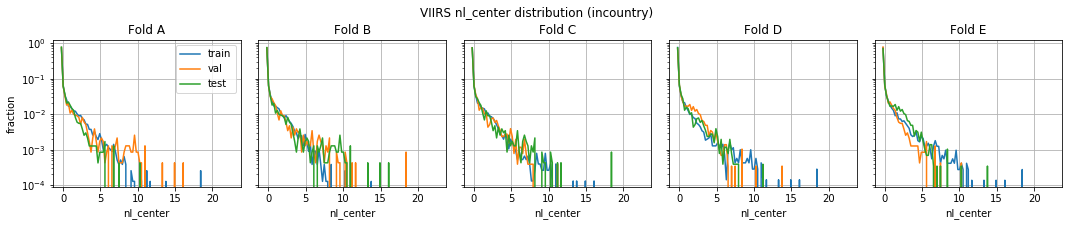

In [41]:
plot_nl_by_fold(df, ooc_folds, col='nl_center', dmsp=True, title='DMSP nl_center distribution (OOC)')
plot_nl_by_fold(df, ooc_folds, col='nl_center', dmsp=False, title='VIIRS nl_center distribution (OOC)')
plot_nl_by_fold(df, incountry_folds, col='nl_center', dmsp=True, title='DMSP nl_center distribution (incountry)')
plot_nl_by_fold(df, incountry_folds, col='nl_center', dmsp=False, title='VIIRS nl_center distribution (incountry)')

In [42]:
def nl_boxplots_by_fold(df, folds, col, dmsp, title=None):
    '''
    Args
    - df: pd.DataFrame
    - folds: dict, folds[f][split] is a np.array of indices
    - col: str, one of ['nl_mean', 'nl_center']
    - dmsp: bool
    - title: str, figure title
    '''
    fig, axs = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(8, 4))
    for f, ax in zip(FOLDS, axs.flat):
        data = []
        for split in SPLITS:
            nls_df = df.loc[folds[f][split], [col, 'year']]
            if dmsp:
                data.append(nls_df.loc[nls_df['year'] < 2012, col])
            else:
                data.append(nls_df.loc[nls_df['year'] >= 2012, col])
        ax.boxplot(data, patch_artist=True, widths=0.8)

        # add x-tick labels
        plt.setp(ax, xticks=[1, 2, 3], xticklabels=SPLITS)

        ax.set_title(f'Fold {f}')
        ax.grid(True, axis='y')

    axs[0].set_ylabel(col)
    if title is not None:
        fig.suptitle(title, y=1.03)
    fig.tight_layout()

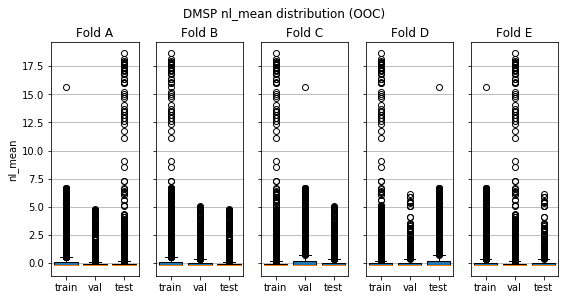

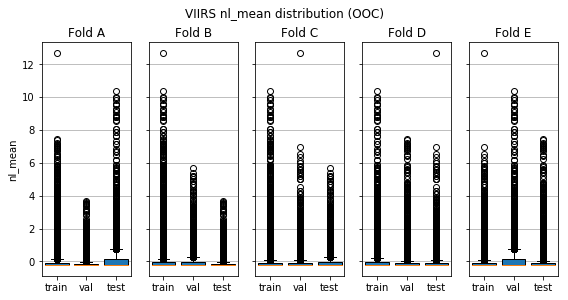

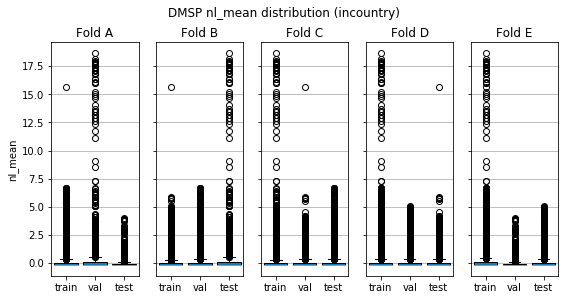

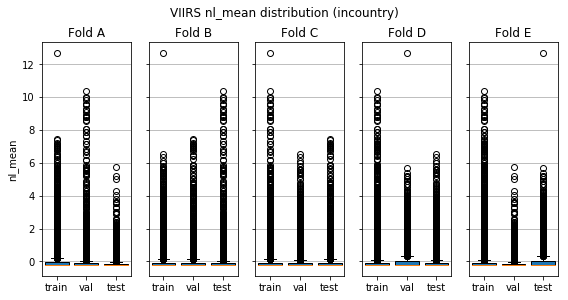

In [43]:
nl_boxplots_by_fold(df, ooc_folds, col='nl_mean', dmsp=True, title='DMSP nl_mean distribution (OOC)')
nl_boxplots_by_fold(df, ooc_folds, col='nl_mean', dmsp=False, title='VIIRS nl_mean distribution (OOC)')
nl_boxplots_by_fold(df, incountry_folds, col='nl_mean', dmsp=True, title='DMSP nl_mean distribution (incountry)')
nl_boxplots_by_fold(df, incountry_folds, col='nl_mean', dmsp=False, title='VIIRS nl_mean distribution (incountry)')

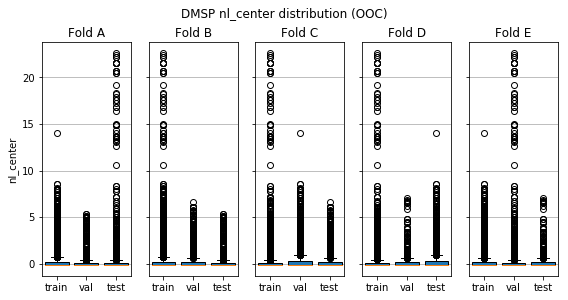

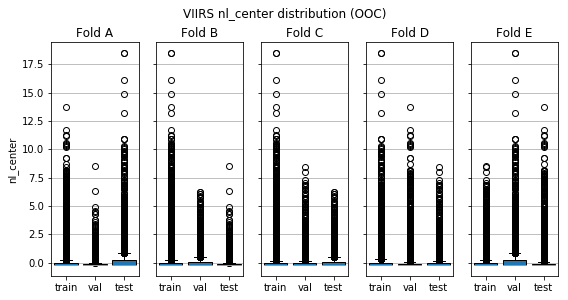

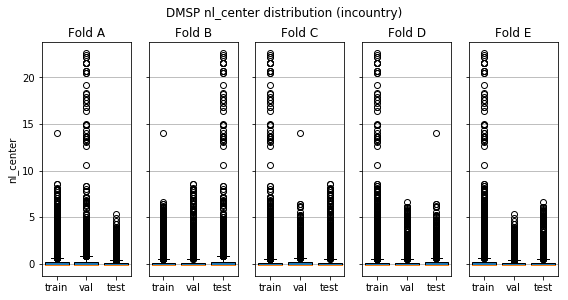

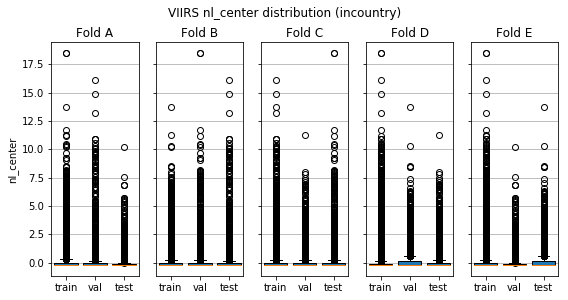

In [44]:
nl_boxplots_by_fold(df, ooc_folds, col='nl_center', dmsp=True, title='DMSP nl_center distribution (OOC)')
nl_boxplots_by_fold(df, ooc_folds, col='nl_center', dmsp=False, title='VIIRS nl_center distribution (OOC)')
nl_boxplots_by_fold(df, incountry_folds, col='nl_center', dmsp=True, title='DMSP nl_center distribution (incountry)')
nl_boxplots_by_fold(df, incountry_folds, col='nl_center', dmsp=False, title='VIIRS nl_center distribution (incountry)')

# Visualize Images

In [45]:
tfrecord_paths = np.asarray(batcher.get_tfrecord_paths(dataset=DATASET, split='all'))
K = 5

In [46]:
def get_images(tfrecord_paths):
    '''
    Args
    - tfrecord_paths: list of str, length N <= 32, paths of TFRecord files

    Returns: np.array, shape [N, 224, 224, 8], type float32
    '''
    init_iter, batch_op = batcher.Batcher(
        tfrecord_files=tfrecord_paths,
        dataset=DATASET,
        batch_size=32,
        ls_bands='ms',
        nl_band='merge',
        label_name='wealthpooled',
        shuffle=False,
        augment=False,
        negatives='zero',
        normalize=True).get_batch()
    with tf.Session() as sess:
        sess.run(init_iter)
        images = sess.run(batch_op['images'])
    return images

In [47]:
def plot_images_by_wealth(indices, images, labels, years, locs,
                          country_labels, countries, title_str):
    '''
    Args
    - indices: np.array, shape [K], type int64
    - images: np.array, shape [K, 224, 224, 8]
    - labels: np.array, shape [N], type float32
    - years: np.array, shape [N], type int32
    - locs: np.array, shape [N, 2], type float32
    - country_labels: np.array, shape [N], type int32
    - countries: list of str, names of countries corresponding to country labels
    - title_str: format str, contains variables [k, label, country, year, lat, lon]
    '''
    for k, i in enumerate(indices):
        img = images[k]
        label, year, loc = labels[i], years[i], locs[i]
        lat, lon = tuple(loc)
        country = countries[country_labels[i]]
        title = title_str.format(k=k+1, label=label, country=country, year=year, lat=lat, lon=lon)
        print(title)
        band_order = list(BAND_ORDER)  # make a copy
        band_order[-1] = 'DMSP' if year < 2012 else 'VIIRS'
        plot_image_by_band(img, band_order, nrows=1, title=None, rgb='merge')

## Highest wealth

Instructions for updating:
Colocations handled automatically by placer.
1-th highest wealth: 2.675832, loc = nigeria 2013 (9.061271, 7.443314)


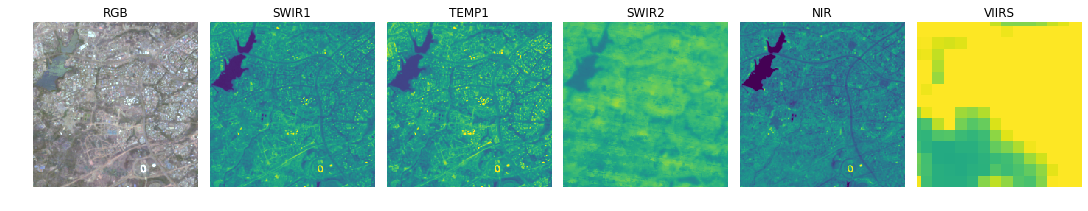

2-th highest wealth: 2.651037, loc = nigeria 2015 (11.994248, 8.557159)


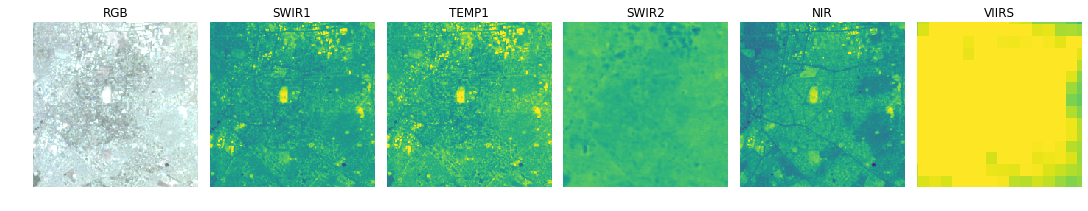

3-th highest wealth: 2.629686, loc = kenya 2014 (-1.240304, 36.836998)


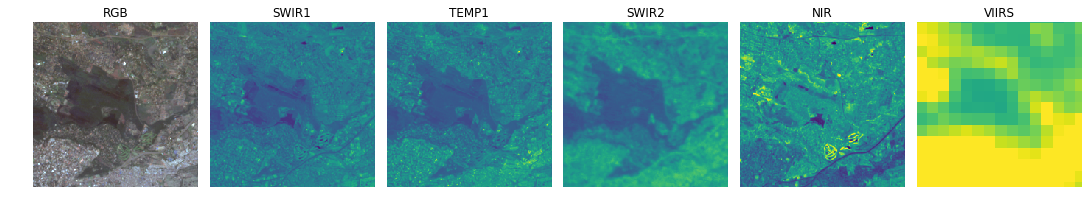

4-th highest wealth: 2.595618, loc = angola 2011 (-12.350257, 13.534922)


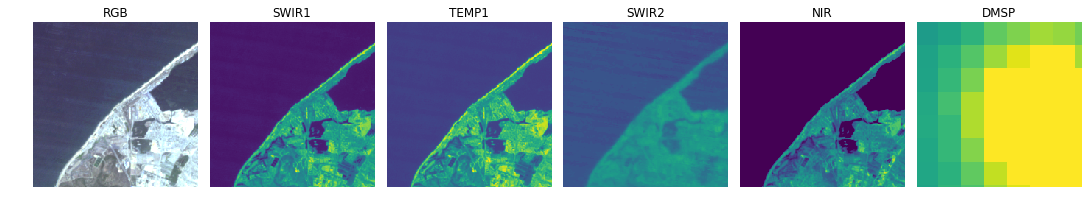

5-th highest wealth: 2.591414, loc = guinea 2012 (10.672460, -14.595328)


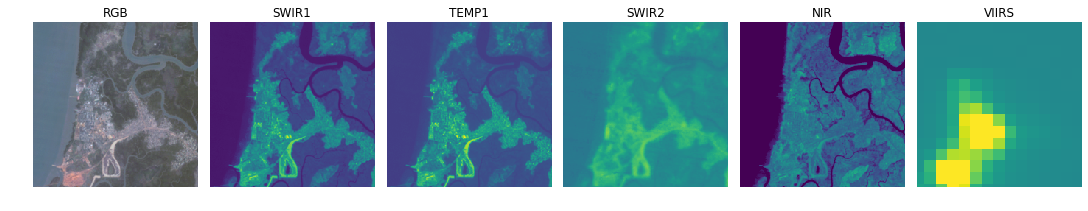

In [48]:
indices = np.argsort(labels)[::-1][:K]  # indices of K wealthiest images
images = get_images(tfrecord_paths[indices])
title_str = '{k}-th highest wealth: {label:.06f}, loc = {country} {year} ({lat:.06f}, {lon:.06f})'
plot_images_by_wealth(indices, images, labels, years, locs,
                      country_labels=country_labels,
                      countries=dataset_constants.DHS_COUNTRIES,
                      title_str=title_str)

## Lowest wealth

1-th lowest wealth: -1.282605, loc = ethiopia 2010 (6.747855, 40.825451)


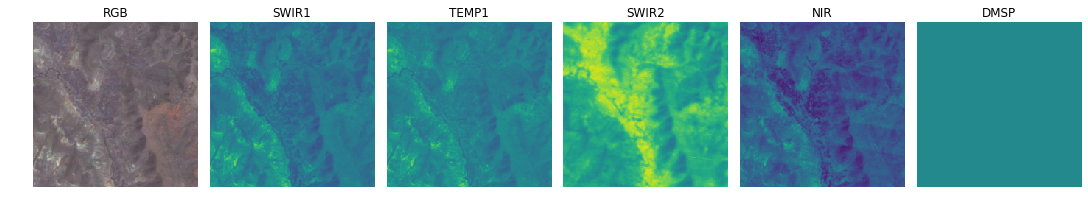

2-th lowest wealth: -1.269092, loc = angola 2011 (-15.874966, 17.406166)


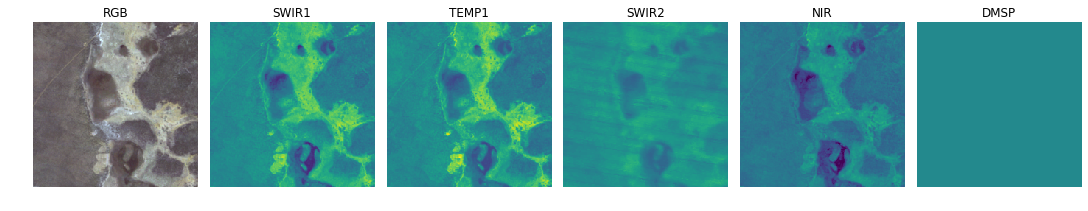

3-th lowest wealth: -1.259074, loc = uganda 2011 (2.552455, 34.717003)


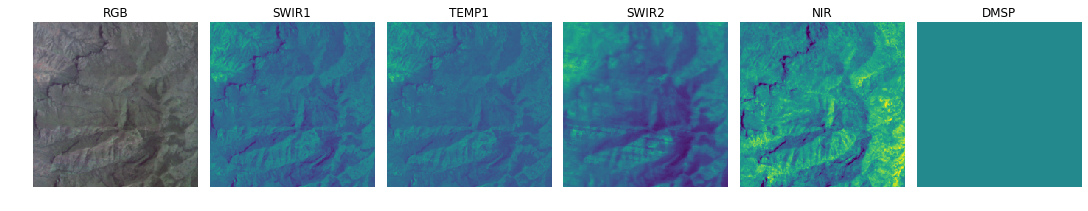

4-th lowest wealth: -1.258386, loc = ethiopia 2010 (8.245896, 34.342964)


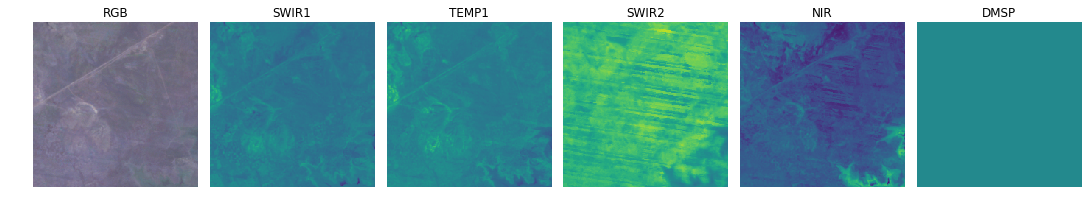

5-th lowest wealth: -1.258183, loc = angola 2011 (-17.277098, 14.603176)


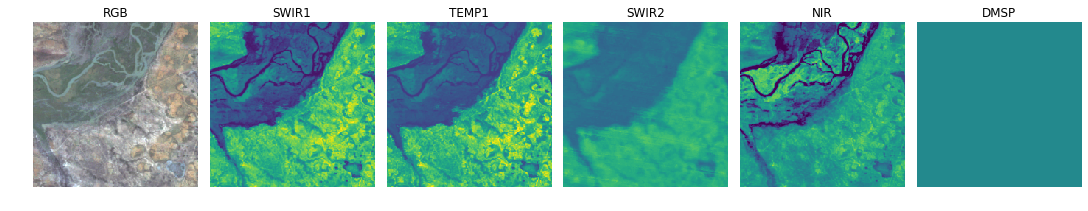

In [49]:
indices = np.argsort(labels)[:K]  # indices of K poorest images
images = get_images(tfrecord_paths[indices])
title_str = '{k}-th lowest wealth: {label:.06f}, loc = {country} {year} ({lat:.06f}, {lon:.06f})'
plot_images_by_wealth(indices, images, labels, years, locs,
                      country_labels=country_labels,
                      countries=dataset_constants.DHS_COUNTRIES,
                      title_str=title_str)